# WeightWatcher DenseNet

https://calculationconsulting.com




### Key Idea in DenseNet 

Dense Connections: connect back to all previous Conv2d feature maps from all previous layers

https://www.jeremyjordan.me/convnet-architectures/#densenet

*"concatenating feature-maps learned by different layers increases variation in the input of subsequent layers and improves efficiency."*



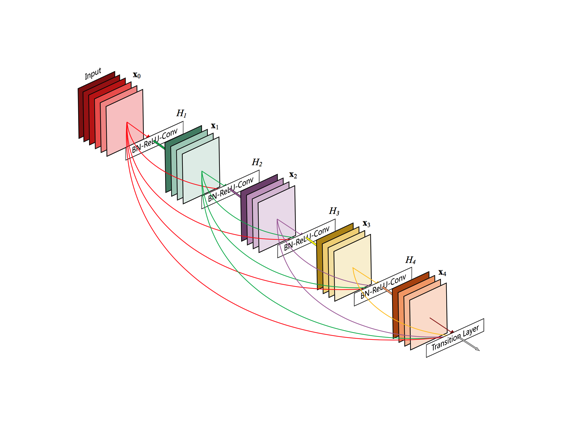

In [8]:
from IPython.display import Image
Image(filename='densenet.png',width=400)

## Summary of Results

A great example of where the $\hat{\alpha}$ does not correlated at all, but the new p-Norm metric does.



In [9]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [10]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [11]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__


Using TensorFlow backend.


'0.2.2'

### Create all models now

In [12]:
series_name = 'DenseNet'
all_names = [ 'densenet121', 'densenet169', 'densenet201', 'densenet161']
colors = ['blue', 'green', 'teal', 'red']

In [13]:
all_models = []
all_models.append(models.densenet121(pretrained=True))
all_models.append(models.densenet161(pretrained=True))
all_models.append(models.densenet169(pretrained=True))
all_models.append(models.densenet201(pretrained=True))


/Users/charleshmartin/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html


<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-even"><td><p>Densenet-121</p></td>
<td><p>25.35</p></td>
<td><p>7.83</p></td>
</tr>
<tr class="row-odd"><td><p>Densenet-169</p></td>
<td><p>24.00</p></td>
<td><p>7.00</p></td>
</tr>
<tr class="row-even"><td><p>Densenet-201</p></td>
<td><p>22.80</p></td>
<td><p>6.43</p></td>
</tr>
<tr class="row-odd"><td><p>Densenet-161</p></td>
<td><p>22.35</p></td>
<td><p>6.20</p></td>
</tr>

</tbody>
</table>
</pre>

In [14]:
top1_errors= {
    
    "densenet121": 25.35,
    "densenet169": 24.00,
    "densenet201": 22.80,
    "densenet161": 22.35 

}

In [15]:
top5_errors= {
    
    "densenet121": 7.83,
    "densenet169": 7.00,
    "densenet201": 6.43,
    "densenet161": 6.20 

}

## Run WeightWatcher, collect summary and details (as dataframes) for all models

In [16]:
all_details = []
all_summaries = []
for im, name in enumerate(all_names):
    watcher = ww.WeightWatcher(model=all_models[im], logger=logger)
    results = watcher.analyze(alphas=True, softranks=True, spectralnorms=True, mp_fit=True)

    summary =  watcher.get_summary()
    all_summaries.append(summary)
    details  = watcher.get_details(results=results)
    details.drop(columns=['slice', 'slice_count'], inplace=True)
    details.dropna(inplace=True)
    details['NxM'] = pd.to_numeric(details.N * details.M)

    all_details.append(details)

In [17]:
plt.rcParams.update({'font.size': 16})
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def plot_test_accuracy(metric, xlabel, title):
    """Create plot of Metric vs Reported Test Accuracy, and run Linear Regression"""
    num = len(all_names)
    xs, ys = np.empty(num), np.empty(num)
    for im, modelname in enumerate(all_names):    

        summary = all_summaries[im]
        x = summary[metric]
        xs[im] = x

        error = top1_errors[modelname]
        y = 100.0-error
        ys[im] = y

        label = modelname
        plt.scatter(x, y, label=label)


    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)
    regr = LinearRegression()
    regr.fit(xs, ys)
    y_pred = regr.predict(xs)
    plt.plot(xs, y_pred, color='red', linewidth=1)

    rmse = np.sqrt(metrics.mean_squared_error(ys, y_pred))
    r2 = metrics.r2_score(ys, y_pred)
    title2 = "RMSE: {0:.2}   R2: {0:.2}".format(rmse, r2)
    
    plt.legend()
    plt.title(r"Test Accuracy vs "+title+"\n"+title2)
    plt.ylabel(r"Test Accuracy")
    plt.xlabel(xlabel);
    plt.show()

In [19]:
def plot_metrics_histogram(metric, xlabel, title, log=False, valid_ids = []):
    transparency = 1.0
    
    if len(valid_ids) == 0:
        valid_ids = range(len(all_details)-1)
        
    for im, details in enumerate(all_details):
        if im in valid_ids:
            vals = details[metric].to_numpy()
            if log:
                vals = np.log10(np.array(vals+0.000001, dtype=np.float))

            plt.hist(vals, bins=100, label=all_names[im], alpha=transparency, color=colors[im], density=True)
            transparency -= 0.15

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

In [20]:
def plot_metrics_depth(metric, ylabel, title, log=False, valid_ids = []):
    transparency = 1.0
    
    if len(valid_ids) == 0:
        valid_ids = range(len(all_details)-1)
        
    for im, details in enumerate(all_details):
        if im in valid_ids:
            
            details = all_details[im]
            name = all_names[im]
            x = details.index.to_numpy()
            y = details[metric].to_numpy()
            if log:
                y = np.log10(np.array(y+0.000001, dtype=np.float))

            plt.scatter(x,y, label=name, color=colors[im])

    plt.legend()
    plt.title(title)
    plt.xlabel("Layer id")
    plt.ylabel(xlabel)
    plt.show()

## Metrics vs Test Accuracy

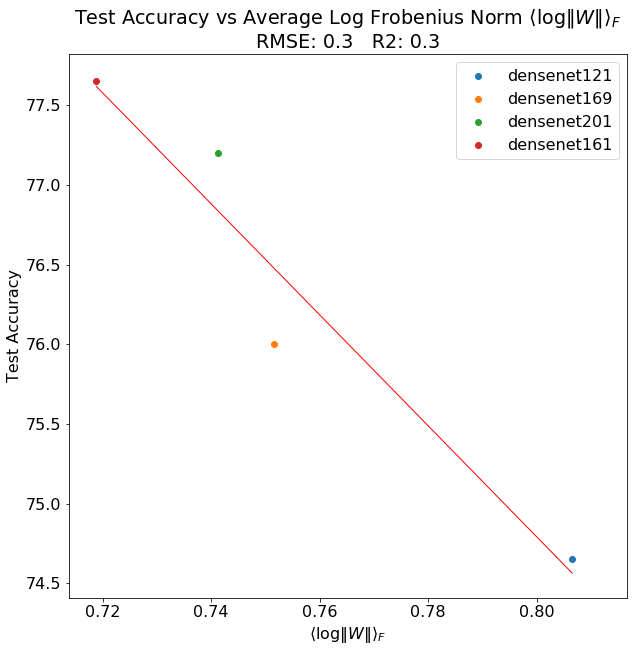

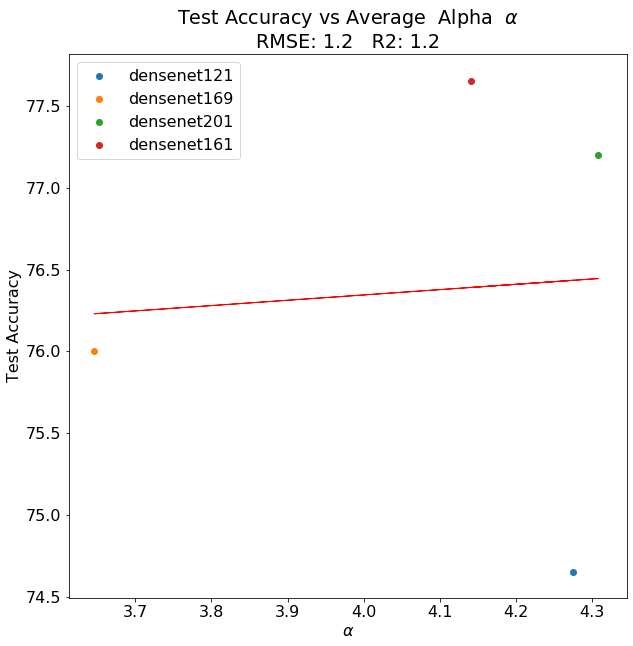

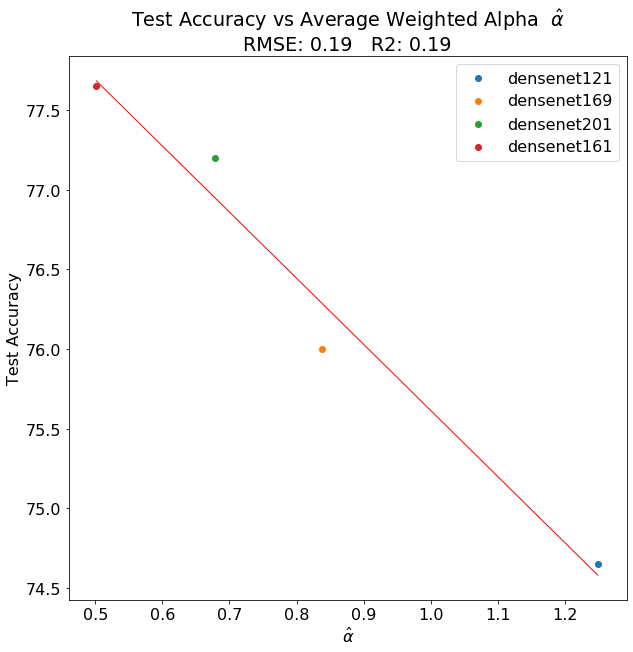

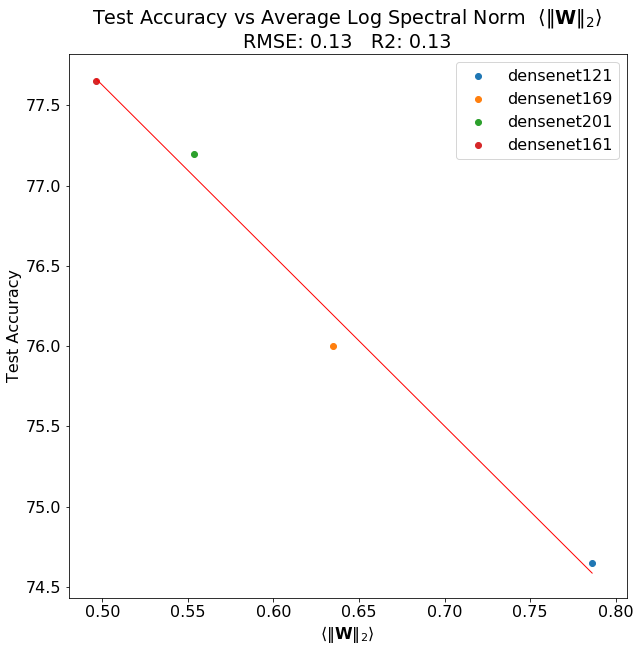

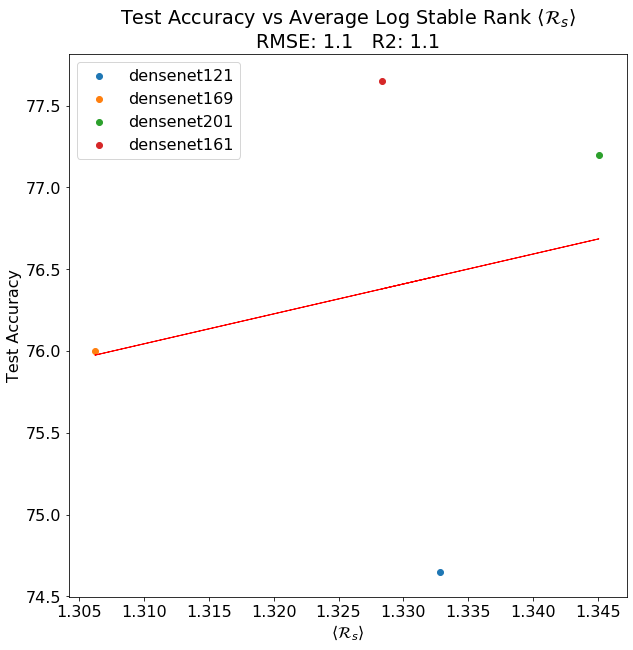

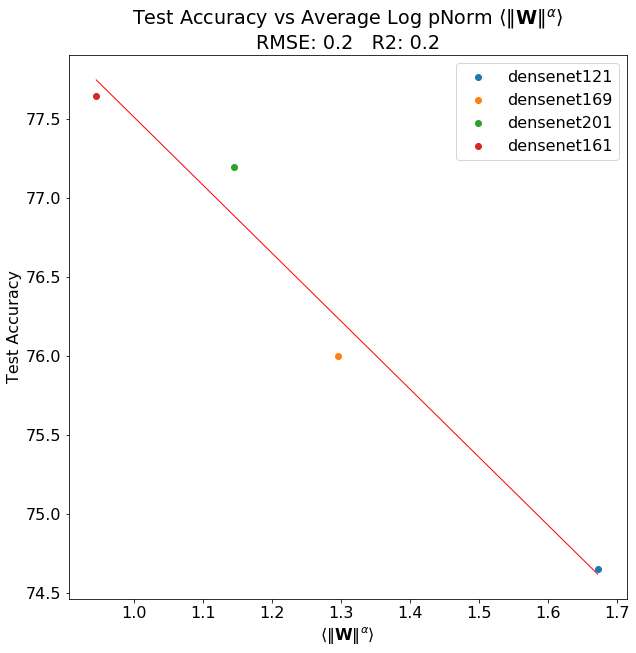

In [21]:
metric = "lognorm"
xlabel = r"$\langle\log\Vert W\Vert\rangle_{F}$"
title = "Average Log Frobenius Norm "+xlabel
plot_test_accuracy(metric, xlabel, title)


metric = "alpha"
xlabel = r"$\alpha$"
title = "Average  Alpha  "+xlabel
plot_test_accuracy(metric, xlabel, title)

metric = "alpha_weighted"
xlabel = r"$\hat{\alpha}$"
title = "Average Weighted Alpha  "+xlabel
plot_test_accuracy(metric, xlabel, title)

metric = "spectralnorm"
xlabel = r"$\langle\Vert\mathbf{W}\Vert_{2}\rangle$"
title = "Average Log Spectral Norm  "+xlabel
plot_test_accuracy(metric, xlabel, title)

metric = "softranklog"
xlabel = r"$\langle\mathcal{R}_{s}\rangle$"
title = "Average Log Stable Rank "+xlabel
plot_test_accuracy(metric, xlabel, title)

metric = "logpnorm"
xlabel = r"$\langle\Vert\mathbf{W}\Vert^{\alpha}\rangle$"
title = "Average Log pNorm "+xlabel
plot_test_accuracy(metric, xlabel, title)

## Histogram of metrics for all layers

In [24]:
first_n_last_ids = [0, len(all_details)-1]

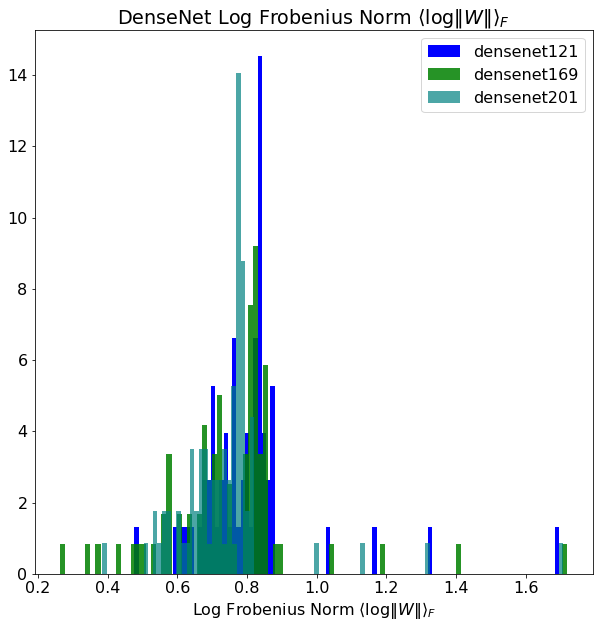

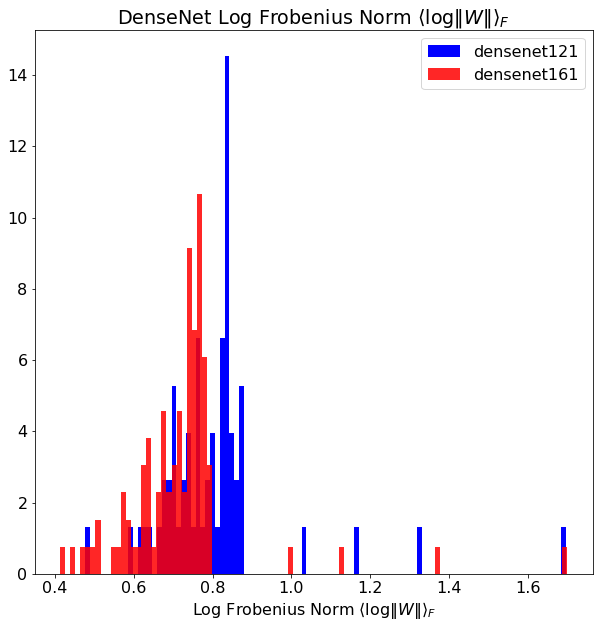

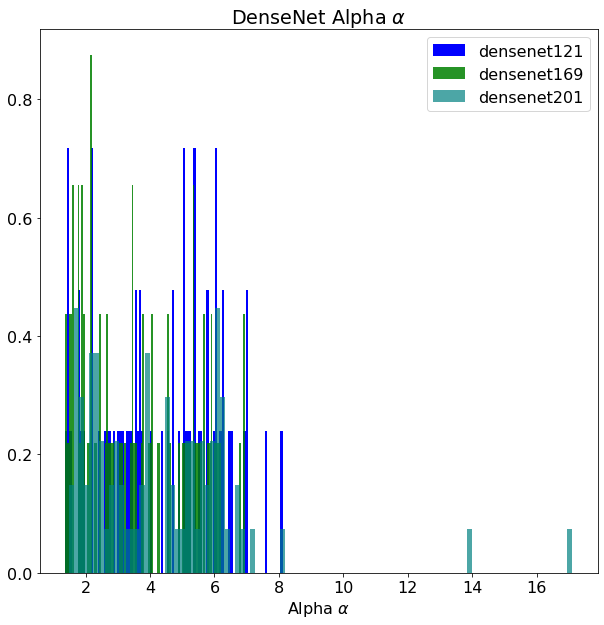

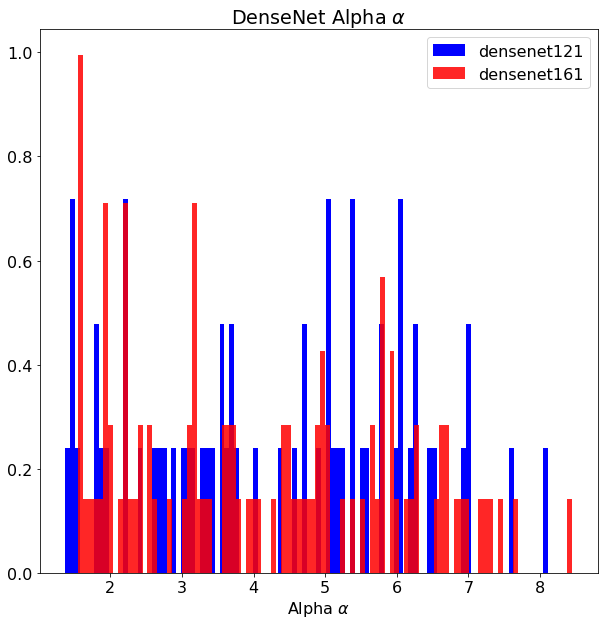

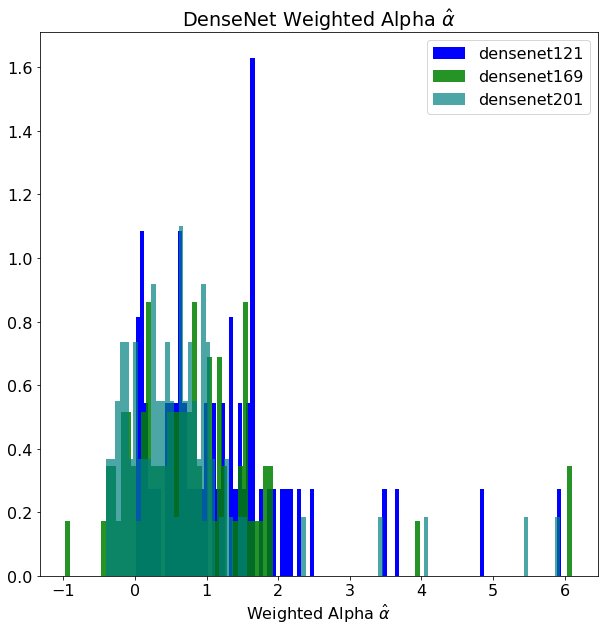

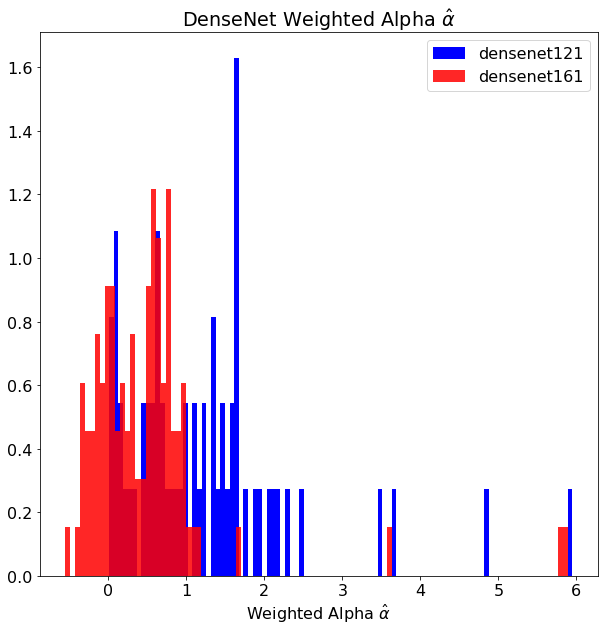

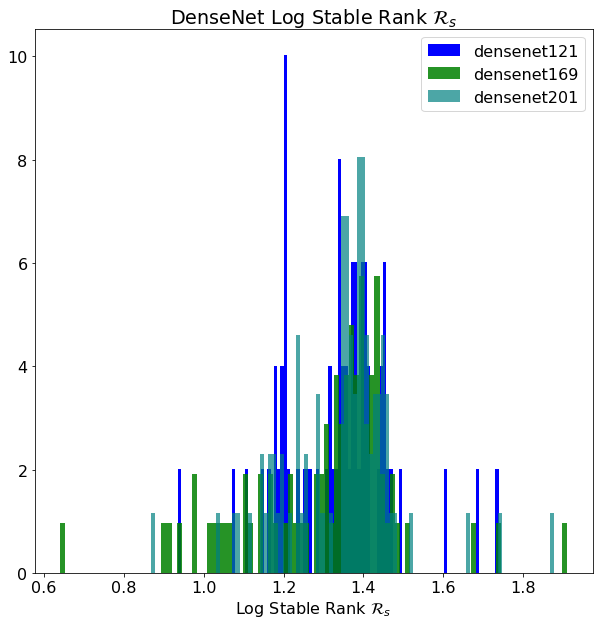

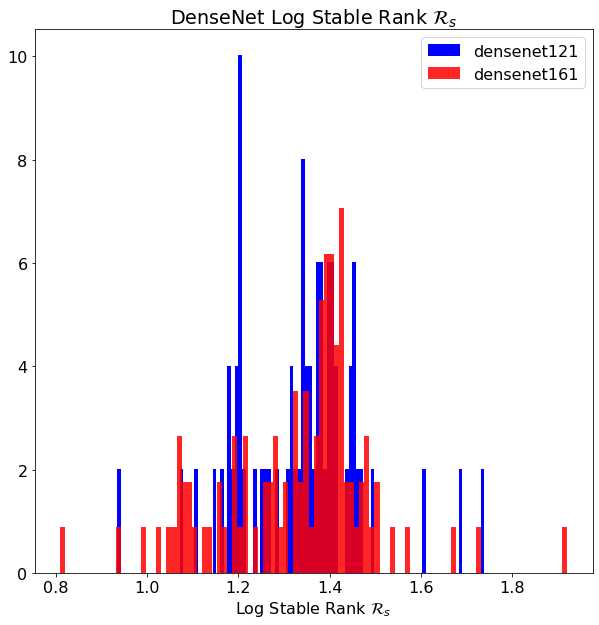

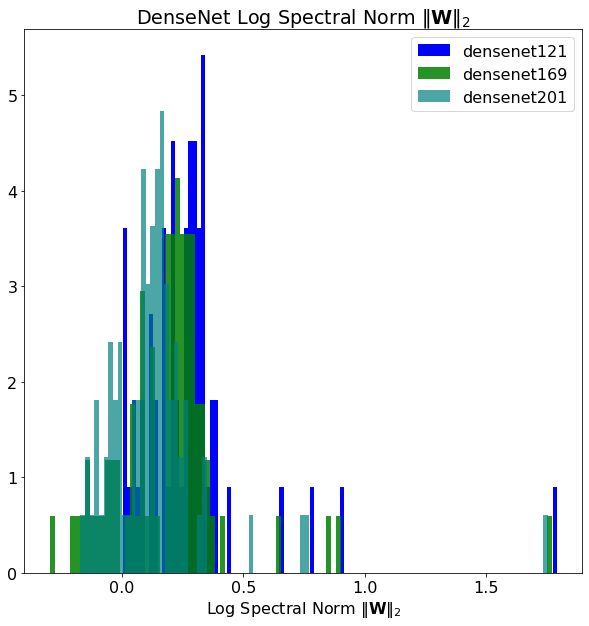

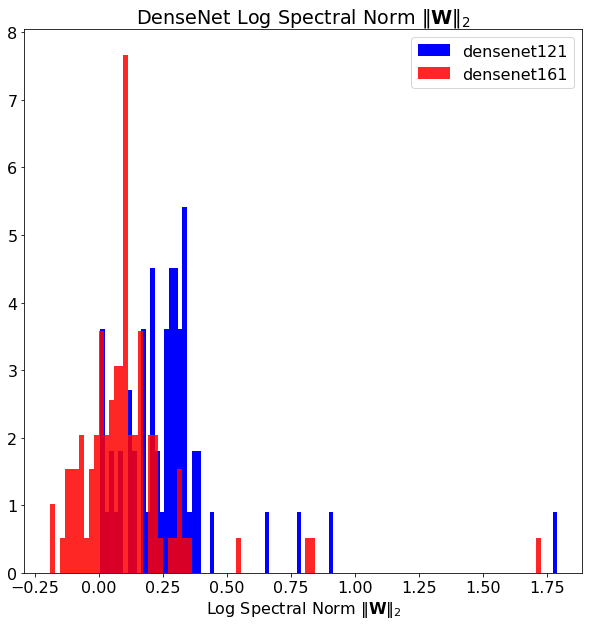

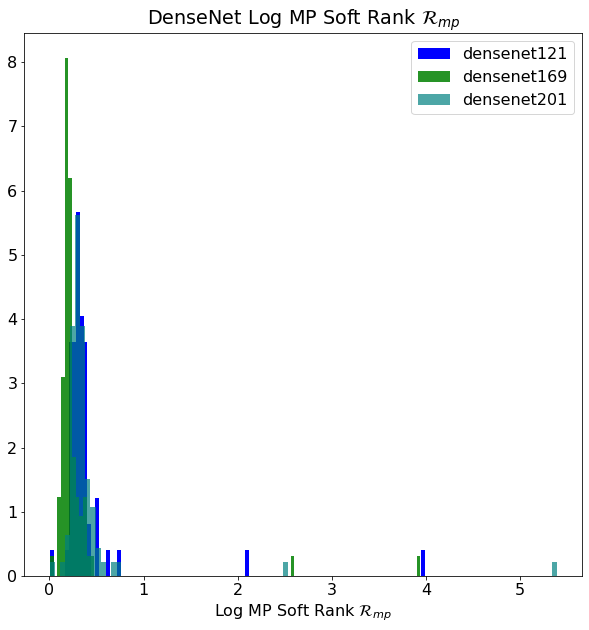

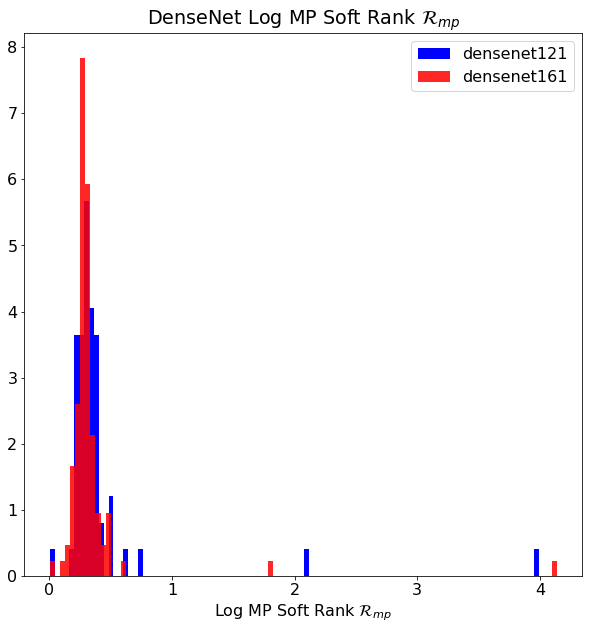

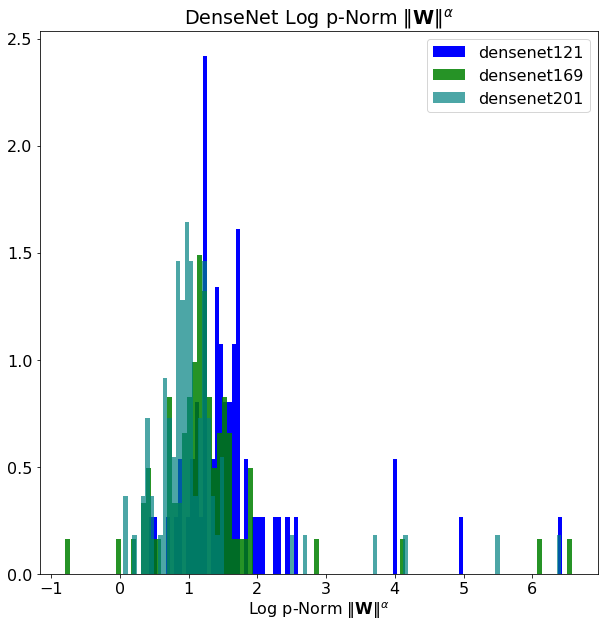

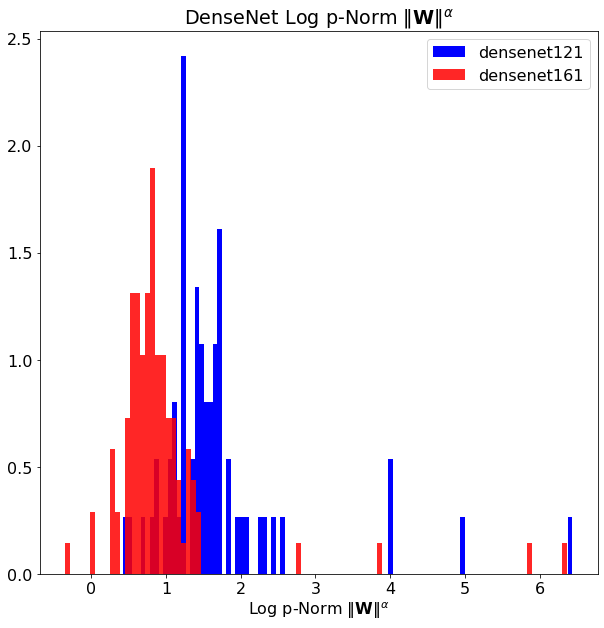

In [22]:
metric = "lognorm"
xlabel = r"Log Frobenius Norm $\langle\log\Vert W\Vert\rangle_{F}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "alpha"
xlabel = r"Alpha $\alpha$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "alpha_weighted"
xlabel = r"Weighted Alpha $\hat{\alpha}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)



metric = "softranklog"
xlabel = r"Log Stable Rank $\mathcal{R}_{s}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "spectralnorm"
xlabel = r"Log Spectral Norm $\Vert\mathbf{W}\Vert_{2}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title, log=True)
plot_metrics_histogram(metric, xlabel, title, log=True, valid_ids = first_n_last_ids)


metric = "softrank_mp"
xlabel = r"Log MP Soft Rank $\mathcal{R}_{mp}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)

metric = "logpnorm"
xlabel = r"Log p-Norm $\Vert\mathbf{W}\Vert^{\alpha}$"
title = series_name+" "+xlabel
plot_metrics_histogram(metric, xlabel, title)
plot_metrics_histogram(metric, xlabel, title, valid_ids = first_n_last_ids)


## Metrics as a function of depth

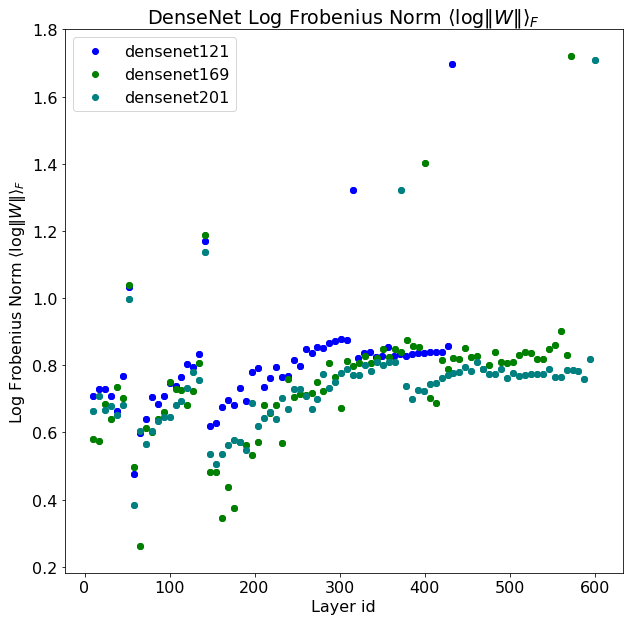

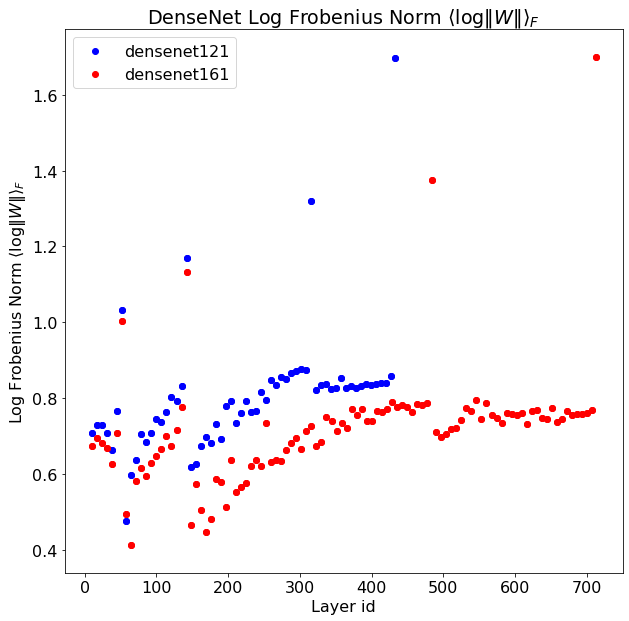

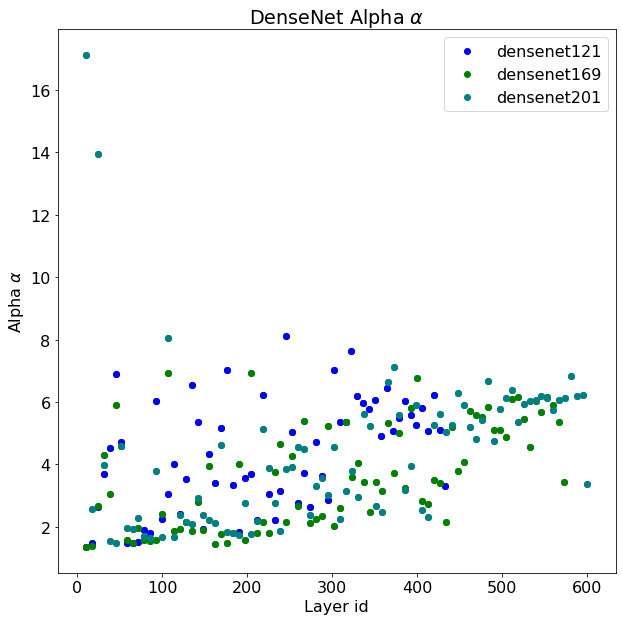

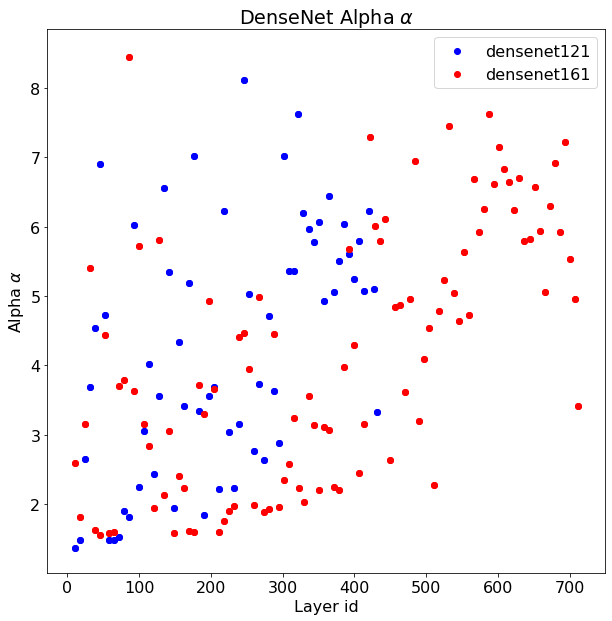

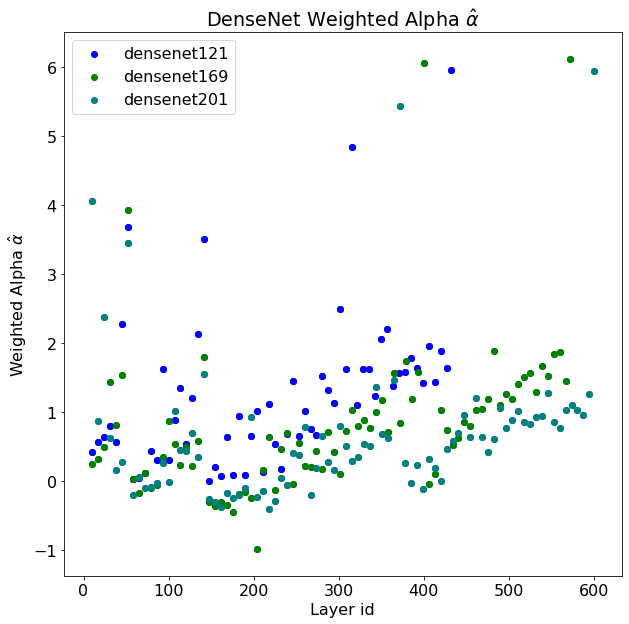

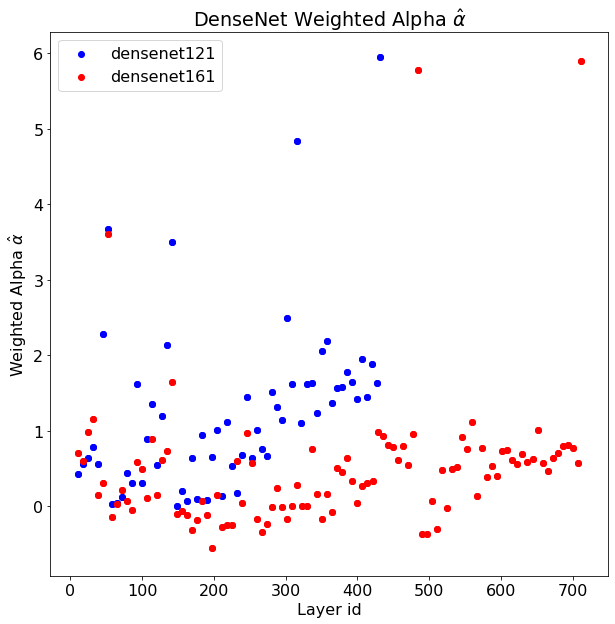

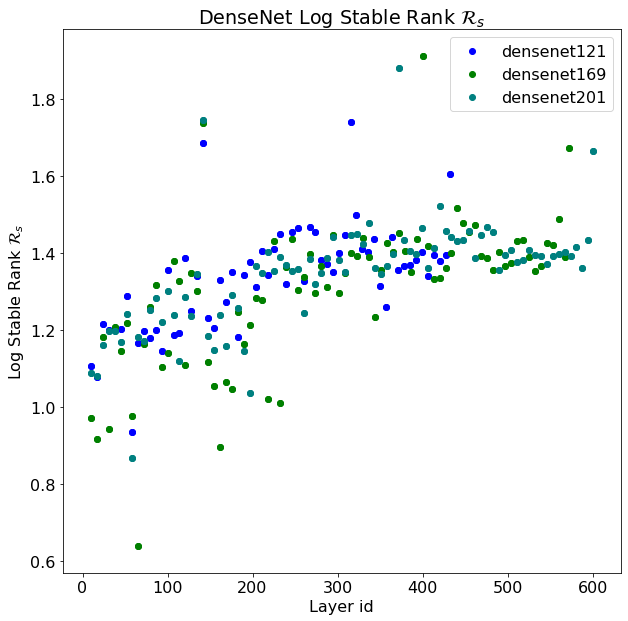

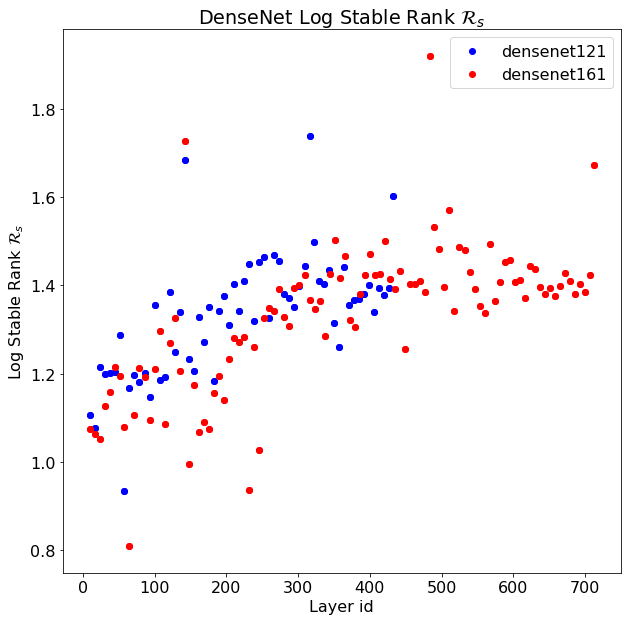

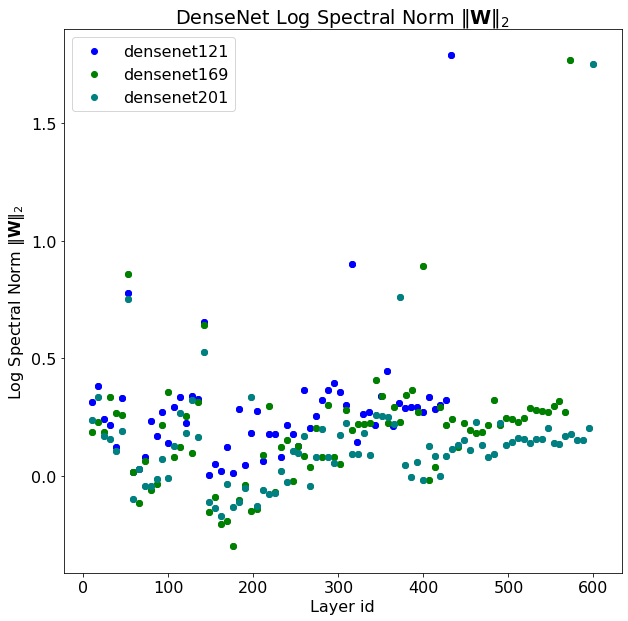

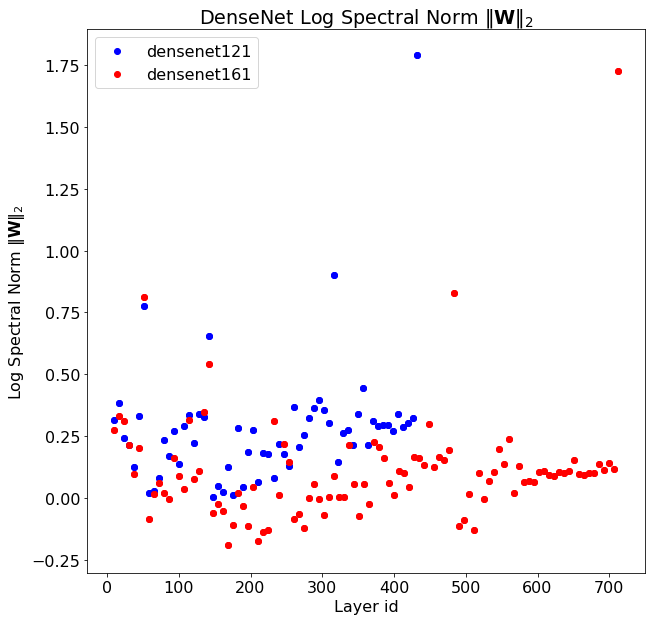

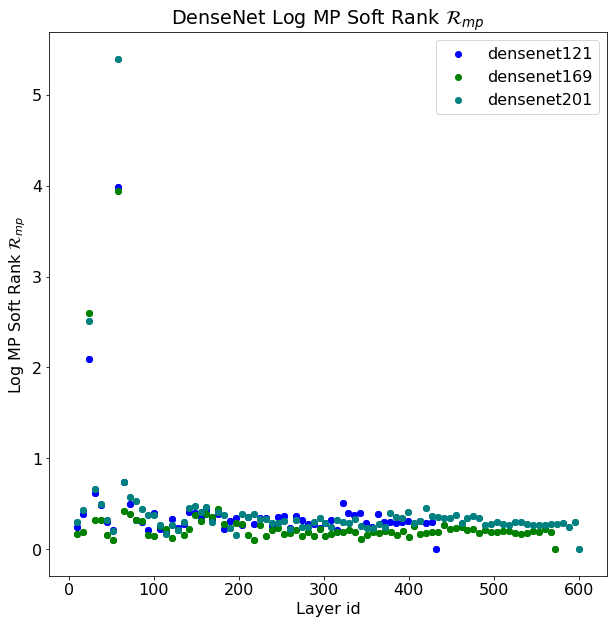

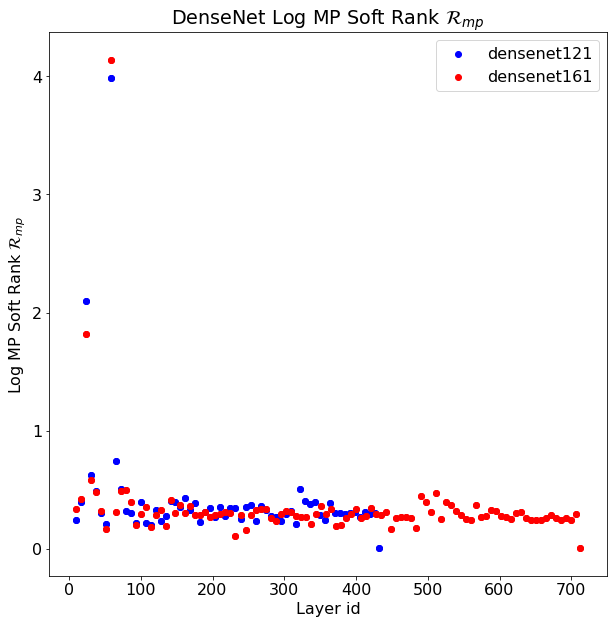

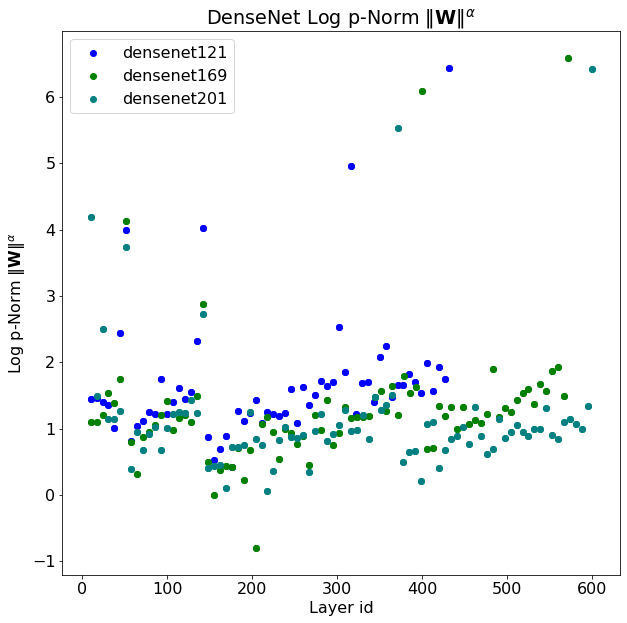

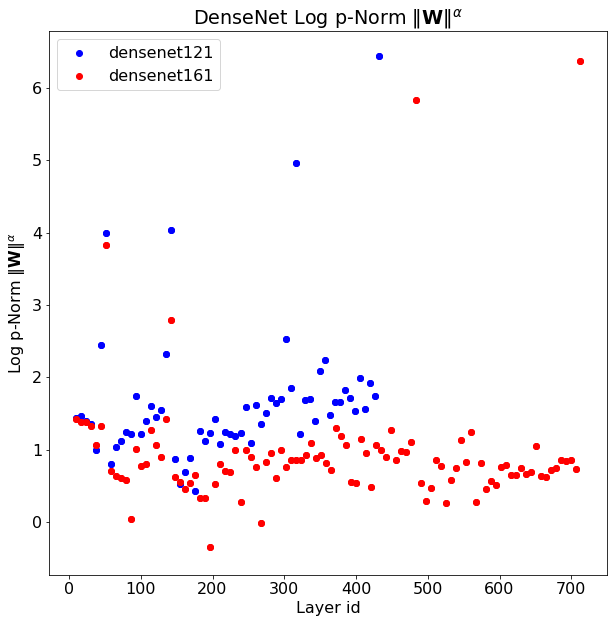

In [23]:
metric = "lognorm"
xlabel = r"Log Frobenius Norm $\langle\log\Vert W\Vert\rangle_{F}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "alpha"
xlabel = r"Alpha $\alpha$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "alpha_weighted"
xlabel = r"Weighted Alpha $\hat{\alpha}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)



metric = "softranklog"
xlabel = r"Log Stable Rank $\mathcal{R}_{s}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)


metric = "spectralnorm"
xlabel = r"Log Spectral Norm $\Vert\mathbf{W}\Vert_{2}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title, log=True)
plot_metrics_depth(metric, xlabel, title, log=True, valid_ids = first_n_last_ids)


metric = "softrank_mp"
xlabel = r"Log MP Soft Rank $\mathcal{R}_{mp}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)

metric = "logpnorm"
xlabel = r"Log p-Norm $\Vert\mathbf{W}\Vert^{\alpha}$"
title = series_name+" "+xlabel
plot_metrics_depth(metric, xlabel, title)
plot_metrics_depth(metric, xlabel, title, valid_ids = first_n_last_ids)